# Feature engineering using pandas_ta package

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_ta as ta
import numpy as np
from multiprocesspandas import applyparallel

In [3]:
train = pd.read_csv('./data/train_files/stock_prices.csv')

In [4]:
train.shape

(2332531, 12)

In [5]:
np.unique(train.AdjustmentFactor.values)

array([ 0.1       ,  0.14285714,  0.2       ,  0.25      ,  0.33333333,
        0.5       ,  0.66666667,  0.76923077,  0.8       ,  0.83333333,
        0.86956522,  0.90909091,  0.95238095,  1.        ,  2.        ,
        4.        ,  5.        , 10.        , 20.        ])

In [6]:
stock_lists = np.unique(train.SecuritiesCode.values)

In [7]:
len(stock_lists)

2000

In [8]:
# Checking for columns with missing calue
train.isna().sum()

RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64

In [10]:
# Remove all rows with null Target

train = train[train['Target'].notna()]

In [11]:
train.isna().sum()

RowId                     0
Date                      0
SecuritiesCode            0
Open                   7370
High                   7370
Low                    7370
Close                  7370
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313429
SupervisionFlag           0
Target                    0
dtype: int64

In [12]:
# Either forward filling or back filling within each group
train = train.sort_values(['Date']).groupby(['SecuritiesCode']).apply(lambda x: x.ffill().bfill())

In [13]:
train.isna().sum()

RowId               0
Date                0
SecuritiesCode      0
Open                0
High                0
Low                 0
Close               0
Volume              0
AdjustmentFactor    0
ExpectedDividend    0
SupervisionFlag     0
Target              0
dtype: int64

In [14]:
# Below code will adjust OHLC and computes features from pandas_ta package
def my_func(df):
    df = df.sort_values("Date", ascending=False)
    # generate CumulativeAdjustmentFactor
    df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()

    df.loc[:,'Open_new'] = df.loc[:,'Open']*df.loc[:,'CumulativeAdjustmentFactor']
    df.loc[:,'High_new'] = df.loc[:,'High']*df.loc[:,'CumulativeAdjustmentFactor']
    df.loc[:,'Low_new'] = df.loc[:,'Low']*df.loc[:,'CumulativeAdjustmentFactor']
    df.loc[:,'Close_new'] = df.loc[:,'Close']*df.loc[:,'CumulativeAdjustmentFactor']
    # reverse order
    df = df.sort_values("Date")
    
    # to fill AdjustedClose, replace 0 into np.nan
    df.loc[df["Close_new"] == 0, "Close_new"] = np.nan
    # forward fill AdjustedClose
    df.loc[:, "Close_new"] = df.loc[:, "Close_new"].ffill()
    
    df.loc[df["Open_new"] == 0, "Open_new"] = np.nan
    df.loc[:, "Open_new"] = df.loc[:, "Open_new"].ffill()

    df.loc[df["High_new"] == 0, "High_new"] = np.nan
    df.loc[:, "High_new"] = df.loc[:, "High_new"].ffill()

    df.loc[df["Low_new"] == 0, "Low_new"] = np.nan
    df.loc[:, "Low_new"] = df.loc[:, "Low_new"].ffill()
    df.set_index(pd.DatetimeIndex(df["Date"]), inplace=True)
    df.drop(['Open','High','Low','Close'],inplace=True,axis=1)
#     print(df.head())
#     print(df.columns)
#     print(df.shape)
    df.columns=['RowId', 'Date', 'SecuritiesCode', 'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target', 'CumulativeAdjustmentFactor', 'Open', 'High','Low', 'Close']
#     print("------")
    df.fillna(0,inplace=True)
    df.ta.strategy()
#     print(df)
    return df
    


In [27]:
%%time
train_new= train.groupby(['SecuritiesCode']).apply_parallel(my_func)

131it [00:02, 64.84it/s] 
55it [00:01, 47.53it/s]] 
131it [00:02, 60.15it/s] 
131it [00:02, 58.83it/s]
131it [00:02, 50.39it/s] 
131it [00:02, 53.55it/s] 
131it [00:02, 50.13it/s]
131it [00:02, 47.83it/s]
131it [00:02, 44.54it/s] 
0it [00:00, ?it/s]0it/s]
131it [00:03, 36.56it/s]
0it [00:00, ?it/s]4it/s]
131it [00:03, 36.89it/s]
131it [00:03, 32.86it/s]
1it [00:04,  4.06s/it]]]
77it [00:05, 49.16it/s]]
40it [00:03, 21.07it/s]] 
104it [00:04, 67.81it/s]
131it [00:04, 31.89it/s]
107it [00:05, 76.47it/s]
130it [00:05, 105.04it/s]
13it [00:03,  5.73it/s]] 

131it [00:04, 32.40it/s]
131it [00:04, 29.70it/s]

102it [00:04, 64.11it/s]
131it [00:04, 28.90it/s]
131it [00:05, 26.00it/s]
131it [00:05, 22.96it/s]
131it [00:05, 23.32it/s]
131it [00:06, 20.48it/s]
131it [00:05, 23.28it/s]
92it [00:03, 73.88it/s]]
9it [00:05,  2.44it/s]s]
1it [00:05,  5.37s/it]]
89it [00:06, 46.76it/s]]
62it [00:06, 26.05it/s]]
72it [00:06, 35.07it/s]]
131it [00:07, 16.41it/s]
131it [00:06, 19.79it/s]
9it [00:06,  1.

CPU times: user 3min 10s, sys: 29.1 s, total: 3min 39s
Wall time: 11min 41s


In [30]:
train_new.set_index(['RowId'],inplace=True)
train_new.reset_index(inplace=True)

In [31]:
train_new.head()

,RowId,Date,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumulativeAdjustmentFactor,Open,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
0,20170104_1301,2017-01-04,1301,31400,1.0,60.0,False,0.000730,1.0,2734.0,...,NaN,NaN,NaN,2742.333333,NaN,2742.25,NaN,NaN,NaN,NaN
1,20170105_1301,2017-01-05,1301,17900,1.0,60.0,False,0.002920,1.0,2743.0,...,NaN,NaN,NaN,2740.000000,NaN,2739.50,NaN,NaN,NaN,NaN
2,20170106_1301,2017-01-06,1301,19900,1.0,60.0,False,-0.001092,1.0,2734.0,...,NaN,NaN,NaN,2734.666667,NaN,2736.00,NaN,NaN,NaN,NaN
3,20170110_1301,2017-01-10,1301,24200,1.0,60.0,False,-0.005100,1.0,2745.0,...,NaN,NaN,NaN,2745.666667,NaN,2746.25,NaN,NaN,NaN,NaN
4,20170111_1301,2017-01-11,1301,9300,1.0,60.0,False,-0.003295,1.0,2748.0,...,NaN,NaN,NaN,2744.666667,NaN,2744.75,NaN,NaN,NaN,NaN


In [44]:
train_new.tail()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
2332288,20211129_9997,2021-11-29,9997,678.0,679.0,665.0,668.0,320800,1.0,9.5,...,744.721735,0.533040,1.334802,670.666667,711.496058,670.00,-97.196262,701.236364,683.087699,-2.137194
2332289,20211130_9997,2021-11-30,9997,670.0,689.0,667.0,667.0,296300,1.0,9.5,...,736.431417,0.550000,1.262500,674.333333,702.843325,672.50,-98.076923,693.036364,673.617209,-1.974133
2332290,20211201_9997,2021-12-01,9997,661.0,688.0,660.0,685.0,339100,1.0,9.5,...,732.397580,0.569767,1.236434,677.666667,698.201102,679.50,-76.190476,689.563636,671.868625,-1.491926
2332291,20211202_9997,2021-12-02,9997,681.0,692.0,680.0,684.0,342900,1.0,9.5,...,728.858832,0.673152,1.206226,685.333333,692.019814,685.00,-76.470588,686.745455,673.347057,-1.424289
2332292,20211203_9997,2021-12-03,9997,690.0,711.0,686.0,696.0,381100,1.0,9.5,...,726.867388,0.710623,1.106227,697.666667,690.495757,697.25,-64.705882,687.018182,682.556683,-1.095587


In [32]:
train_new.shape

(2332293, 291)

In [34]:
# Rows with NAN values
cols_to_replace=train_new.isna().sum()[train_new.isna().sum()>0].index

In [35]:
cols_to_replace

Index(['ABER_ZG_5_15', 'ABER_SG_5_15', 'ABER_XG_5_15', 'ABER_ATR_5_15',
       'ACCBL_20', 'ACCBM_20', 'ACCBU_20', 'ADOSC_3_10', 'ADX_14', 'DMP_14',
       ...
       'VHF_28', 'VIDYA_14', 'VTXP_14', 'VTXM_14', 'VWAP_D', 'VWMA_10',
       'WILLR_14', 'WMA_10', 'ZL_EMA_10', 'ZS_30'],
      dtype='object', length=166)

In [36]:
# Replacing NAN in these columns with median value 
%%time
train_new[cols_to_replace] = train_new[cols_to_replace].fillna(train_new.groupby('SecuritiesCode')[cols_to_replace].transform('median'))

In [37]:
train_new.isna().sum()[train_new.isna().sum()>0].index

Index(['EOM_14_100000000'], dtype='object')

In [45]:
# train_new[train_new['EOM_14_100000000'].isna()][[ 'Date','SecuritiesCode',  'EOM_14_100000000']].SecuritiesCode.value_counts()

In [46]:
train_new[train_new.SecuritiesCode==1301]

,RowId,Date,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumulativeAdjustmentFactor,Open,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
0,20170104_1301,2017-01-04,1301,31400,1.0,60.0,False,0.000730,1.0,2734.0,...,2976.583702,0.971326,0.947243,2742.333333,2994.202712,2742.25,-48.717949,2995.418182,2995.427311,0.107992
1,20170105_1301,2017-01-05,1301,17900,1.0,60.0,False,0.002920,1.0,2743.0,...,2976.583702,0.971326,0.947243,2740.000000,2994.202712,2739.50,-48.717949,2995.418182,2995.427311,0.107992
2,20170106_1301,2017-01-06,1301,19900,1.0,60.0,False,-0.001092,1.0,2734.0,...,2976.583702,0.971326,0.947243,2734.666667,2994.202712,2736.00,-48.717949,2995.418182,2995.427311,0.107992
3,20170110_1301,2017-01-10,1301,24200,1.0,60.0,False,-0.005100,1.0,2745.0,...,2976.583702,0.971326,0.947243,2745.666667,2994.202712,2746.25,-48.717949,2995.418182,2995.427311,0.107992
4,20170111_1301,2017-01-11,1301,9300,1.0,60.0,False,-0.003295,1.0,2748.0,...,2976.583702,0.971326,0.947243,2744.666667,2994.202712,2744.75,-48.717949,2995.418182,2995.427311,0.107992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,20211129_1301,2021-11-29,1301,14300,1.0,70.0,False,0.003793,1.0,2975.0,...,3037.083778,0.792619,1.210896,2962.000000,3028.046414,2959.25,-100.000000,3012.818182,2976.362668,-1.761376
1198,20211130_1301,2021-11-30,1301,20500,1.0,70.0,False,0.007558,1.0,2953.0,...,3030.483448,0.780687,1.117840,2932.333333,2999.038033,2924.25,-100.000000,2988.072727,2943.387637,-2.345622
1199,20211201_1301,2021-12-01,1301,10600,1.0,70.0,False,0.016706,1.0,2909.0,...,3024.174541,0.786284,1.149920,2918.666667,2981.568966,2916.75,-95.217391,2968.872727,2920.408067,-1.953316
1200,20211202_1301,2021-12-02,1301,15200,1.0,70.0,False,-0.003689,1.0,2949.0,...,3020.474704,0.814871,1.060698,2946.333333,2970.545685,2943.00,-85.652174,2957.472727,2911.424782,-1.494301


In [48]:
train_new.loc[:,'Weekday'] = pd.to_datetime(train_new['Date']).dt.day_name() #pd.DatetimeIndex(df.Date).to_series().dt.day_name()

In [49]:
train_new.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [50]:
train_new.columns.values

array(['RowId', 'Date', 'SecuritiesCode', 'Volume', 'AdjustmentFactor',
       'ExpectedDividend', 'SupervisionFlag', 'Target',
       'CumulativeAdjustmentFactor', 'Open', 'High', 'Low', 'Close',
       'ABER_ZG_5_15', 'ABER_SG_5_15', 'ABER_XG_5_15', 'ABER_ATR_5_15',
       'ACCBL_20', 'ACCBM_20', 'ACCBU_20', 'AD', 'ADOSC_3_10', 'ADX_14',
       'DMP_14', 'DMN_14', 'ALMA_10_6.0_0.85', 'AMATe_LR_8_21_2',
       'AMATe_SR_8_21_2', 'AO_5_34', 'OBV', 'OBV_min_2', 'OBV_max_2',
       'OBVe_4', 'OBVe_12', 'AOBV_LR_2', 'AOBV_SR_2', 'APO_12_26',
       'AROOND_14', 'AROONU_14', 'AROONOSC_14', 'ATRr_14', 'BBL_5_2.0',
       'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'BIAS_SMA_26',
       'BOP', 'AR_26', 'BR_26', 'CCI_14_0.015', 'CDL_2CROWS',
       'CDL_3BLACKCROWS', 'CDL_3INSIDE', 'CDL_3LINESTRIKE',
       'CDL_3OUTSIDE', 'CDL_3STARSINSOUTH', 'CDL_3WHITESOLDIERS',
       'CDL_ABANDONEDBABY', 'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD',
       'CDL_BREAKAWAY', 'CDL_CLOSINGMARUBOZU', 'CDL_CONCE

In [51]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332293 entries, 0 to 2332292
Columns: 292 entries, RowId to Weekday
dtypes: bool(1), float64(266), int64(22), object(3)
memory usage: 5.1+ GB


In [52]:
train_new.head()

,RowId,Date,SecuritiesCode,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumulativeAdjustmentFactor,Open,...,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30,Weekday
0,20170104_1301,2017-01-04,1301,31400,1.0,60.0,False,0.000730,1.0,2734.0,...,0.971326,0.947243,2742.333333,2994.202712,2742.25,-48.717949,2995.418182,2995.427311,0.107992,Wednesday
1,20170105_1301,2017-01-05,1301,17900,1.0,60.0,False,0.002920,1.0,2743.0,...,0.971326,0.947243,2740.000000,2994.202712,2739.50,-48.717949,2995.418182,2995.427311,0.107992,Thursday
2,20170106_1301,2017-01-06,1301,19900,1.0,60.0,False,-0.001092,1.0,2734.0,...,0.971326,0.947243,2734.666667,2994.202712,2736.00,-48.717949,2995.418182,2995.427311,0.107992,Friday
3,20170110_1301,2017-01-10,1301,24200,1.0,60.0,False,-0.005100,1.0,2745.0,...,0.971326,0.947243,2745.666667,2994.202712,2746.25,-48.717949,2995.418182,2995.427311,0.107992,Tuesday
4,20170111_1301,2017-01-11,1301,9300,1.0,60.0,False,-0.003295,1.0,2748.0,...,0.971326,0.947243,2744.666667,2994.202712,2744.75,-48.717949,2995.418182,2995.427311,0.107992,Wednesday


In [53]:
train_new['Date'] = pd.to_datetime(train_new['Date'])

In [54]:
%%time
# Saving data for each year separately
train_new[train_new.Date.dt.year==2017].to_parquet('./data/train_df_2017.parquet', engine='fastparquet')
train_new[train_new.Date.dt.year==2018].to_parquet('./data/train_df_2018.parquet', engine='fastparquet')
train_new[train_new.Date.dt.year==2019].to_parquet('./data/train_df_2019.parquet', engine='fastparquet')
train_new[train_new.Date.dt.year==2020].to_parquet('./data/train_df_2020.parquet', engine='fastparquet')
train_new[train_new.Date.dt.year==2021].to_parquet('./data/train_df_2021.parquet', engine='fastparquet')

CPU times: user 37.2 s, sys: 4.08 s, total: 41.3 s
Wall time: 56.3 s


# End of feature creation - After this use generalml_p37_cpu_v1 package

# Start from here for model building - From here use generalml_p37_cpu_v1 package

In [50]:
import numpy as np

In [1]:
# Using 2017 data for training & Validation and 2018 for testing
import pandas as pd
train_df =pd.read_parquet("./train_df_2017.parquet")
test_df = pd.read_parquet("./train_df_2018.parquet")

In [2]:
%%time
# import libraries
import ads
import pandas as pd
import logging
import seaborn as sns
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator

CPU times: user 9.68 s, sys: 5.31 s, total: 15 s
Wall time: 9.14 s


In [3]:
train_df.isna().sum()[train_df.isna().sum()>0].index

Index(['EOM_14_100000000'], dtype='object')

In [4]:
test_df.isna().sum()[test_df.isna().sum()>0].index

Index(['EOM_14_100000000'], dtype='object')

In [5]:
train_df = train_df[train_df['EOM_14_100000000'].notna()]
test_df = test_df[test_df['EOM_14_100000000'].notna()]

In [6]:
test_df.isnull().sum().sum()

0

In [7]:
train_df.isnull().sum().sum()

0

In [8]:
train_df.columns.values

array(['RowId', 'Date', 'SecuritiesCode', 'Volume', 'AdjustmentFactor',
       'ExpectedDividend', 'SupervisionFlag', 'Target',
       'CumulativeAdjustmentFactor', 'Open', 'High', 'Low', 'Close',
       'ABER_ZG_5_15', 'ABER_SG_5_15', 'ABER_XG_5_15', 'ABER_ATR_5_15',
       'ACCBL_20', 'ACCBM_20', 'ACCBU_20', 'AD', 'ADOSC_3_10', 'ADX_14',
       'DMP_14', 'DMN_14', 'ALMA_10_6.0_0.85', 'AMATe_LR_8_21_2',
       'AMATe_SR_8_21_2', 'AO_5_34', 'OBV', 'OBV_min_2', 'OBV_max_2',
       'OBVe_4', 'OBVe_12', 'AOBV_LR_2', 'AOBV_SR_2', 'APO_12_26',
       'AROOND_14', 'AROONU_14', 'AROONOSC_14', 'ATRr_14', 'BBL_5_2.0',
       'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'BIAS_SMA_26',
       'BOP', 'AR_26', 'BR_26', 'CCI_14_0.015', 'CDL_2CROWS',
       'CDL_3BLACKCROWS', 'CDL_3INSIDE', 'CDL_3LINESTRIKE',
       'CDL_3OUTSIDE', 'CDL_3STARSINSOUTH', 'CDL_3WHITESOLDIERS',
       'CDL_ABANDONEDBABY', 'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD',
       'CDL_BREAKAWAY', 'CDL_CLOSINGMARUBOZU', 'CDL_CONCE

In [9]:
reqd_columns=[ 
    'ABER_ZG_5_15', 'ABER_SG_5_15', 'ABER_XG_5_15', 'ABER_ATR_5_15',
       'ACCBL_20', 'ACCBM_20', 'ACCBU_20', 'AD', 'ADOSC_3_10', 'ADX_14',
       'DMP_14', 'DMN_14', 'ALMA_10_6.0_0.85', 'AMATe_LR_8_21_2',
       'AMATe_SR_8_21_2', 'AO_5_34', 'OBV', 'OBV_min_2', 'OBV_max_2',
       'OBVe_4', 'OBVe_12', 'AOBV_LR_2', 'AOBV_SR_2', 'APO_12_26',
       'AROOND_14', 'AROONU_14', 'AROONOSC_14', 'ATRr_14', 'BBL_5_2.0',
       'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'BIAS_SMA_26',
       'BOP', 'AR_26', 'BR_26', 'CCI_14_0.015', 'CDL_2CROWS',
       'CDL_3BLACKCROWS', 'CDL_3INSIDE', 'CDL_3LINESTRIKE',
       'CDL_3OUTSIDE', 'CDL_3STARSINSOUTH', 'CDL_3WHITESOLDIERS',
       'CDL_ABANDONEDBABY', 'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD',
       'CDL_BREAKAWAY', 'CDL_CLOSINGMARUBOZU', 'CDL_CONCEALBABYSWALL',
       'CDL_COUNTERATTACK', 'CDL_DARKCLOUDCOVER', 'CDL_DOJI_10_0.1',
       'CDL_DOJISTAR', 'CDL_DRAGONFLYDOJI', 'CDL_ENGULFING',
       'CDL_EVENINGDOJISTAR', 'CDL_EVENINGSTAR', 'CDL_GAPSIDESIDEWHITE',
       'CDL_GRAVESTONEDOJI', 'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI',
       'CDL_HARAMICROSS', 'CDL_HIGHWAVE', 'CDL_HIKKAKE', 'CDL_HIKKAKEMOD',
       'CDL_HOMINGPIGEON', 'CDL_IDENTICAL3CROWS', 'CDL_INNECK',
       'CDL_INSIDE', 'CDL_INVERTEDHAMMER', 'CDL_KICKING',
       'CDL_KICKINGBYLENGTH', 'CDL_LADDERBOTTOM', 'CDL_LONGLEGGEDDOJI',
       'CDL_LONGLINE', 'CDL_MARUBOZU', 'CDL_MATCHINGLOW', 'CDL_MATHOLD',
       'CDL_MORNINGDOJISTAR', 'CDL_MORNINGSTAR', 'CDL_ONNECK',
       'CDL_PIERCING', 'CDL_RICKSHAWMAN', 'CDL_RISEFALL3METHODS',
       'CDL_SEPARATINGLINES', 'CDL_SHOOTINGSTAR', 'CDL_SHORTLINE',
       'CDL_SPINNINGTOP', 'CDL_STALLEDPATTERN', 'CDL_STICKSANDWICH',
       'CDL_TAKURI', 'CDL_TASUKIGAP', 'CDL_THRUSTING', 'CDL_TRISTAR',
       'CDL_UNIQUE3RIVER', 'CDL_UPSIDEGAP2CROWS', 'CDL_XSIDEGAP3METHODS',
       'open_Z_30_1', 'high_Z_30_1', 'low_Z_30_1', 'close_Z_30_1',
       'CFO_9', 'CG_10', 'CHOP_14_1_100', 'CKSPl_10_3_20',
       'CKSPs_10_3_20', 'CMF_20', 'CMO_14', 'COPC_11_14_10', 'CTI_12',
       'LDECAY_5', 'DEC_1', 'DEMA_10', 'DCL_20_20', 'DCM_20_20',
       'DCU_20_20', 'DPO_20', 'EBSW_40_10', 'EFI_13', 'EMA_10', 'ENTP_10',
       'EOM_14_100000000', 'ER_10', 'BULLP_13', 'BEARP_13', 'FISHERT_9_1',
       'FISHERTs_9_1', 'FWMA_10', 'HA_open', 'HA_high', 'HA_low',
       'HA_close', 'HILO_13_21', 'HILOl_13_21', 'HILOs_13_21', 'HL2',
       'HLC3', 'HMA_10', 'HWM', 'HWU', 'HWL', 'HWMA_0.2_0.1_0.1', 'ISA_9',
       'ISB_26', 'ITS_9', 'IKS_26', 'ICS_26', 'INC_1', 'INERTIA_20_14',
       'JMA_7_0', 'KAMA_10_2_30', 'KCLe_20_2', 'KCBe_20_2', 'KCUe_20_2',
       'K_9_3', 'D_9_3', 'J_9_3', 'KST_10_15_20_30_10_10_10_15', 'KSTs_9',
       'KURT_30', 'KVO_34_55_13', 'KVOs_34_55_13', 'LR_14', 'LOGRET_1',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'MAD_30',
       'MASSI_9_25', 'MCGD_10', 'MEDIAN_30', 'MFI_14', 'MIDPOINT_2',
       'MIDPRICE_2', 'MOM_10', 'NATR_14', 'NVI_1', 'OHLC4', 'PDIST',
       'PCTRET_1', 'PGO_14', 'PPO_12_26_9', 'PPOh_12_26_9',
       'PPOs_12_26_9', 'PSARl_0.02_0.2', 'PSARs_0.02_0.2',
       'PSARaf_0.02_0.2', 'PSARr_0.02_0.2', 'PSL_12', 'PVI_1',
       'PVO_12_26_9', 'PVOh_12_26_9', 'PVOs_12_26_9', 'PVOL', 'PVR',
       'PVT', 'PWMA_10', 'QQE_14_5_4.236', 'QQE_14_5_4.236_RSIMA',
       'QQEl_14_5_4.236', 'QQEs_14_5_4.236', 'QS_10', 'QTL_30_0.5',
       'RMA_10', 'ROC_10', 'RSI_14', 'RSX_14', 'RVGI_14_4', 'RVGIs_14_4',
       'RVI_14', 'SINWMA_14', 'SKEW_30', 'SLOPE_1', 'SMA_10',
       'SMI_5_20_5', 'SMIs_5_20_5', 'SMIo_5_20_5', 'SQZ_20_2.0_20_1.5',
       'SQZ_ON', 'SQZ_OFF', 'SQZ_NO', 'SQZPRO_20_2.0_20_2_1.5_1',
       'SQZPRO_ON_WIDE', 'SQZPRO_ON_NORMAL', 'SQZPRO_ON_NARROW',
       'SQZPRO_OFF', 'SQZPRO_NO', 'SSF_10_2', 'STC_10_12_26_0.5',
       'STCmacd_10_12_26_0.5', 'STCstoch_10_12_26_0.5', 'STDEV_30',
       'STOCHk_14_3_3', 'STOCHd_14_3_3', 'STOCHRSIk_14_14_3_3',
       'STOCHRSId_14_14_3_3', 'SUPERT_7_3.0', 'SUPERTd_7_3.0',
       'SUPERTl_7_3.0', 'SUPERTs_7_3.0', 'SWMA_10', 'T3_10_0.7',
       'TEMA_10', 'THERMO_20_2_0.5', 'THERMOma_20_2_0.5',
       'THERMOl_20_2_0.5', 'THERMOs_20_2_0.5', 'TOS_STDEVALL_LR',
       'TOS_STDEVALL_L_1', 'TOS_STDEVALL_U_1', 'TOS_STDEVALL_L_2',
       'TOS_STDEVALL_U_2', 'TOS_STDEVALL_L_3', 'TOS_STDEVALL_U_3',
       'TRIMA_10', 'TRIX_30_9', 'TRIXs_30_9', 'TRUERANGE_1',
       'TSI_13_25_13', 'TSIs_13_25_13', 'TTM_TRND_6', 'UI_14',
       'UO_7_14_28', 'VAR_30', 'VHF_28', 'VIDYA_14', 'VTXP_14', 'VTXM_14',
       'VWAP_D', 'VWMA_10', 'WCP', 'WILLR_14', 'WMA_10', 'ZL_EMA_10',
       'ZS_30', 'Weekday','Target']

In [10]:
final_df4 = train_df[reqd_columns]

In [11]:
ds = DatasetFactory.from_dataframe(final_df4,target="Target")

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
%%time
train, test = ds.train_test_split(test_size=0.1)

CPU times: user 1.64 s, sys: 447 ms, total: 2.09 s
Wall time: 2.1 s


In [13]:
%%time
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.dataset.factory import DatasetFactory
## USE ADS for model building
import ads
import logging
import seaborn as sns
from ads.evaluations.evaluator import ADSEvaluator

CPU times: user 29 µs, sys: 11 µs, total: 40 µs
Wall time: 49.6 µs


In [14]:
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator

In [ ]:
%%time
# this is the default AutoML provider for regression and classification problem types.
# over time Oracle will introduce other providers for other training tasks.
ml_engine = OracleAutoMLProvider()
oracle_automl = AutoML(train, provider=ml_engine)
automl_model1, baseline1 = oracle_automl.train(time_budget=1000)

In [34]:
automl_model1.summary()

Framework: sklearn.ensemble._forest
Estimator class: ExtraTreesRegressor
Model Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 0.777777778, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.000625, 'min_samples_split': 0.00125, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 16, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}



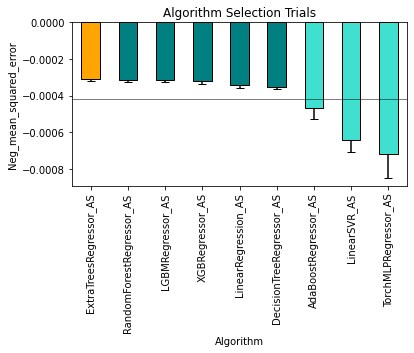

In [35]:
oracle_automl.visualize_algorithm_selection_trials()

In [ ]:
# # model to explain and the train/test dataset
# from ads.explanations.explainer import ADSExplainer
# explainer = ADSExplainer(test, automl_model1, training_data=train)

# # # With ADSExplainer, create a global explanation object using
# # # the MLXGlobalExplainer provider


# # # A summary of the global feature permutation importance algorithm and
# # # how to interpret the output can be displayed with
# # global_explainer.feature_importance_summary()

# # # Compute the global Feature Permutation Importance explanation
# # importances = global_explainer.compute_feature_importance()

# # # ADS supports multiple visualizations for the global Feature
# # # Permutation Importance explanations (see "Interpretation" above)

# # # Simple bar chart highlighting the average impact on model score
# # # across multiple iterations of the algorithm
# # importances.show_in_notebook()

In [ ]:
# from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
# global_explainer = explainer.global_explanation(provider=MLXGlobalExplainer())

In [ ]:
# importances = global_explainer.compute_feature_importance()

### check why above is not working

In [36]:
result=test_df.loc[:,['Date','SecuritiesCode','Target']]

In [37]:
# predict
result.loc[:,'predictions'] = automl_model1.predict(test_df[reqd_columns])

INFO:automl.preprocessing:transform: After dropping constant and mangled columns Index(['CDL_3STARSINSOUTH'], dtype='object'). Updated shape : (459831, 279)
INFO:automl.preprocessing:transform: After feature engineering and transformations. Updated shape : (459831, 278)


In [39]:
# result

In [40]:
# list(set(result.SecuritiesCode.values))

In [41]:
import matplotlib.pyplot as plt

(-0.1, 0.1)

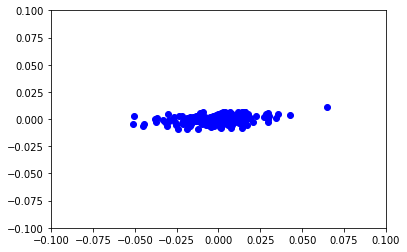

In [42]:
tmp = result[result.SecuritiesCode==1301]
plt.plot(tmp.Target, tmp.predictions,'bo')
ax = plt.gca()
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])

(-0.1, 0.1)

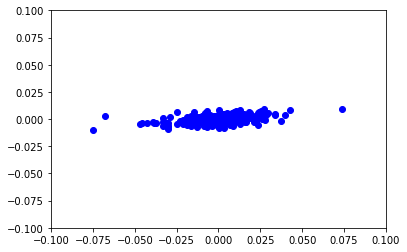

In [43]:
tmp = result[result.SecuritiesCode==8194]
plt.plot(tmp.Target, tmp.predictions,'bo')
ax = plt.gca()
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])

(-0.1, 0.1)

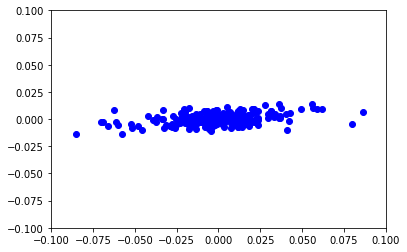

In [44]:
tmp = result[result.SecuritiesCode==9997]
plt.plot(tmp.Target, tmp.predictions,'bo')
ax = plt.gca()
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])

In [45]:
%%time
import ads 
ads.set_auth(auth='resource_principal')

CPU times: user 43 µs, sys: 1e+03 ns, total: 44 µs
Wall time: 64.4 µs


In [46]:
from ads.model.framework.automl_model import AutoMLModel
artifact_dir = "./artifacts"
automl_model = AutoMLModel(estimator=automl_model1, artifact_dir=artifact_dir)

In [47]:
from ads.common.model_metadata import UseCaseType
automl_model.prepare(inference_conda_env="generalml_p37_cpu_v1",
                    training_conda_env="generalml_p37_cpu_v1",
                    use_case_type=UseCaseType.REGRESSION,
                    X_sample=test.X,
                    force_overwrite=True,
                    training_id=None)
automl_model.verify(test.X.iloc[:10])

INFO:xengine:All work stopped
INFO:xengine:All work stopped
INFO:automl.xengine:Using Single Node XEngine with n_jobs: 1
INFO:automl.xengine:Max timeout per task is set to 1500
INFO:automl.xengine:local xengine initialization: <multiprocessing.pool.Pool object at 0x7f69eb8fb610>
Start loading model.pkl from model directory /home/datascience/Kaggle_JPX_Tokyo_Stock_Exchange/artifacts ...
Model is successfully loaded.
INFO:automl.preprocessing:transform: After dropping constant and mangled columns Index(['CDL_3STARSINSOUTH'], dtype='object'). Updated shape : (10, 279)
INFO:automl.preprocessing:transform: After feature engineering and transformations. Updated shape : (10, 278)


{'prediction': [-0.005203958366337782,
  0.005011734011728636,
  -0.0019323913514562475,
  0.012136185935496025,
  -0.005721919342268875,
  -0.007767256604731536,
  0.007142512465972941,
  0.00841459139146188,
  -0.00044946908244642396,
  -0.00042115608206895217]}

In [48]:
model_id = automl_model.save(display_name='Sharpe_Model')

INFO:xengine:All work stopped
INFO:xengine:All work stopped
INFO:automl.xengine:Using Single Node XEngine with n_jobs: 1
INFO:automl.xengine:Max timeout per task is set to 1500
INFO:automl.xengine:local xengine initialization: <multiprocessing.pool.Pool object at 0x7f65406f1050>
Start loading model.pkl from model directory /home/datascience/Kaggle_JPX_Tokyo_Stock_Exchange/artifacts ...
Model is successfully loaded.
['input_schema.json', 'runtime.yaml', 'test_json_output.json', 'score.py', 'model.pkl']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_af9ad442-c291-480a-94ae-a714b887ab0c.zip


In [51]:

def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with Rank
    """
    # sort records to set Rank
    df = df.sort_values("predictions", ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank_predictions"] = np.arange(len(df["predictions"]))
    
    # sort records to set Rank
    df = df.sort_values("Target", ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank_actuals"] = np.arange(len(df["Target"]))
    return df

# result = result.sort_values(["Date", "predict"], ascending=[True, False])
result = result.groupby("Date").apply(set_rank)

In [53]:
result.set_index(['Date'],inplace=True)

In [54]:
result.reset_index(inplace=True)

In [55]:
result

,Date,SecuritiesCode,Target,predictions,Rank_predictions,Rank_actuals
0,2018-01-04,4572,0.268097,0.010513,100,0
1,2018-01-04,6626,0.194301,0.013579,35,1
2,2018-01-04,7952,0.193685,0.015452,15,2
3,2018-01-04,6264,0.151042,0.014529,23,3
4,2018-01-04,3540,0.144913,0.011842,67,4
...,...,...,...,...,...,...
459826,2018-12-28,1429,-0.042506,-0.005901,1838,1893
459827,2018-12-28,8111,-0.043328,-0.009487,1885,1894
459828,2018-12-28,4025,-0.050000,-0.010333,1889,1895
459829,2018-12-28,3498,-0.050909,0.013827,19,1896


In [56]:
result.columns

Index(['Date', 'SecuritiesCode', 'Target', 'predictions', 'Rank_predictions',
       'Rank_actuals'],
      dtype='object')

In [ ]:
# result.columns = ['Date', 'level_1', 'SecuritiesCode', 'predictions', 'Target', 'Rank']

In [57]:
result['Rank_actuals'] = result.groupby('Date')['Target'].rank(ascending = False, method = 'first') - 1 
result['Rank_actuals'] = result['Rank_actuals'].astype('int')
result['Rank_predictions'] = result.groupby('Date')['predictions'].rank(ascending = False, method = 'first') - 1 
result['Rank_predictions'] = result['Rank_predictions'].astype('int')

In [58]:
result.head()

,Date,SecuritiesCode,Target,predictions,Rank_predictions,Rank_actuals
0,2018-01-04,4572,0.268097,0.010513,100,0
1,2018-01-04,6626,0.194301,0.013579,35,1
2,2018-01-04,7952,0.193685,0.015452,15,2
3,2018-01-04,6264,0.151042,0.014529,23,3
4,2018-01-04,3540,0.144913,0.011842,67,4


In [67]:
def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio, return_column, rank_column):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df[rank_column].min() == 0
    assert df[rank_column].max() == len(df[rank_column]) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by=rank_column)[return_column][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by=rank_column, ascending=False)[return_column][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short




def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio, return_column = 'Target', rank_column='Rank_actuals')
    sharpe_ratio = buf.mean() / buf.std()
    print("actual sharpe .. ", sharpe_ratio)

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio,return_column = 'predictions', rank_column='Rank_predictions')
    sharpe_ratio = buf.mean() / buf.std()
    print("predicted sharpe .. ", sharpe_ratio)


In [68]:
result.Date.min(), result.Date.max()

(Timestamp('2018-01-04 00:00:00'), Timestamp('2018-12-28 00:00:00'))

In [69]:
# calc_spread_return_sharpe(result[(result.Date>='2018-06-04') & (result.Date<'2018-06-12')], portfolio_size=200)

In [70]:
import numpy as np
calc_spread_return_sharpe(result, portfolio_size=200)

actual sharpe ..  5.027712558874397
predicted sharpe ..  7.038995784068879
